In [2]:
#importowanie bibliotek
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, LabelEncoder
from nltk.stem.porter import PorterStemmer
import nltk
from nltk.corpus import stopwords
import re
import string
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import xgboost as xgb
from langdetect import detect

import warnings
#warnings.filterwarnings('ignore')


ModuleNotFoundError: No module named 'langdetect'

In [ ]:
df = pd.read_csv("PreProcessedData.csv")

In [ ]:
#df = df.sample(frac=0.5) #zeby szybciej sie uczylo, potem wezmiemy calosc

In [ ]:
df.head()

In [ ]:
df.info()

# Usuwanie tekstów w innych językach z całej ramki

In [ ]:
lang=[]
for index, row in df.iterrows():
    try:
        lang.append(detect(row['title']))
    except:
        try:
            lang.append(detect(row['text']))
        except:
            lang.append(111)

In [ ]:
language=pd.Series(lang)

In [ ]:
new_df=pd.concat([df, language], axis=1, join='inner')

In [ ]:
new_df.info()

In [ ]:
new_df.rename(columns = {0:'lang'}, inplace = True)

In [ ]:
list(new_df)

In [ ]:
new_df=new_df[new_df['lang']=='en']

In [ ]:
new_df=new_df[['Unnamed: 0', 'title', 'text', 'Ground Label']]

In [ ]:
new_df.head()

In [ ]:
#ramka z usunietymi tekstami w innym jezyku
df=new_df

In [ ]:
df.rename(columns = {'Ground Label': 'label'},inplace=True)

In [ ]:
#usunm ta jedna kolumne bo jest useless
df.drop(df.columns[0], inplace=True, axis=1)

In [ ]:
df.head()

In [ ]:
#splitting the data
x_train, x_val, y_train, y_val = train_test_split(df[['title','text']], df['label'], test_size=0.3, random_state=10)

In [ ]:
df=pd.concat([x_train, y_train], axis=1, join='inner')

In [ ]:
df.head()

In [ ]:
df.loc[df.duplicated()]

In [ ]:
df.loc[ df['title'].str.contains('Goes Down, Loretta', na=False)  ]

Mamy 4600 duplikatów spośród 48 000 wierszy. Warto by było usunąć te duplikaty w zbiorze treningowym, bo nic nie wnoszą sensownego

In [ ]:
df.drop_duplicates(inplace = True)

In [ ]:
df.loc[df.duplicated()]

# 1. Analiza całokształtu zadania - CEL

Cel projektu : mamy title newsa, text i ground label czyli informacje czy to jest fake czy nie -> 
Musimy stworzyc model klasyfikacji ktory bedzie stwierdzać, czy dany artykuł jest prawdziwy czy nie.

# 2. Wizualizacja danych

In [ ]:
df.info()

In [ ]:
df.shape

In [ ]:
df['label'].value_counts()

In [ ]:
sns.countplot(df['label'])
plt.title('Number of fake news and true news')
plt.show()

In [ ]:
df['title'].str.len().hist(bins=[0,3,20,50,75,100,150,200,300,400])
plt.title('Histogram - TITLE length')
plt.show()

In [ ]:
df['text'].str.len().hist(bins=[0,50,200,300,1000,2000,3000,5000,20000,90000])
plt.title('Histogram - TEXT length')
plt.show()

In [ ]:
df.isna().sum() #tytuł będziemy doklejać do tekstu

In [ ]:
#average title length in each text
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))

len_word_true=df[df['label']=='true']['title'].str.len()
sns.distplot(len_word_true.map(lambda x: np.mean(x)),ax=ax1,color='green')
ax1.set_xlim([0,250])
ax1.set_title('Original title')

len_word_false=df[df['label']=='fake']['title'].str.len()
sns.distplot(len_word_false.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_xlim([0,250])
ax2.set_title('Fake text')

fig.suptitle('Average title length in each text')

plt.show()

In [ ]:
#average word length in each text
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
len_word_true=df[df['label']=='true']['text'].str.len()
sns.distplot(len_word_true.map(lambda x: np.mean(x)),ax=ax1,color='green')
ax1.set_title('Original text')
ax1.set_xlim([-100,20000])

len_word_false=df[df['label']=='fake']['text'].str.len()
sns.distplot(len_word_false.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Fake text')

fig.suptitle('Average text length in each text')
ax2.set_xlim([-100,20000])
plt.show()

In [ ]:
df.loc[df['text'].isna()]

In [71]:
df.loc[df['title'].isna()]

,title,text,label
65456,NaN,I thought Trump didn't like people who were ca...,fake
47562,NaN,"Except, of course, other US weaponry.\r\nWhere...",fake
19007,NaN,"You know, if the guy really is about restoring...",fake
52131,NaN,$4 Billion even after they are known to be kee...,fake
43532,NaN,Googles Alphabet Experiment Misses Goal: Keep...,fake
...,...,...,...
10401,NaN,Part 3 Mary Worship https://www.youtube.com/wa...,fake
3707,NaN,what about in the winter?? anyone got an answe...,fake
54340,NaN,We Are Change \r\nProject Veritas continues wi...,fake
46514,NaN,Ah the old pump and dump. The market should b...,fake


In [72]:
df.loc[ ( df['title'].isna() ) &  ( df['text'].isna() )]

,title,text,label


In [73]:
df.loc[( df['text'].str.len() < 30 )  & (df['title'].str.len()<30)]

,title,text,label
13184,Hillary’s Watergate?,,fake
29457,World War 3?,,fake


# 3. Preprocessing

# 3.0 SPLITTING DATA

In [74]:
#splitting the data
x_train, x_test, y_train, y_test = train_test_split(df[['title','text']], df['label'], test_size=0.3, random_state=10) 
# a co zeby zrobic warstwowe probkowanie i zachowac stosunek?

In [75]:
x_train.head()

,title,text
18710,Catalan independence campaign kicks off as Bar...,"TARRAGONA, Spain (Reuters) - The Catalonian go..."
34036,AWESOME! HISPANIC TRUMP SUPPORTER Rips Into Pr...,
37386,Man To Howard University Students: ‘It’s Not M...,Red Flag Warning: These California Wildfires A...
42829,"NY Sanitation Workers Block Driver, Hurl Raci...",If you don t think that Donald Trump s horribl...
10060,Trump to order reversal of Obama water regulat...,WASHINGTON (Reuters) - U.S. President Donald T...


In [76]:
y_train.head()

18710    true
34036    fake
37386    fake
42829    fake
10060    true
Name: label, dtype: object

# 3.1 Preprocessing and Text Mining 

# TODO: Usuńmy wiersze z innymi językam

In [78]:
stopwor = stopwords.words('English')

In [79]:
def preprocess_text(text):
    
    #lowercase text
    text = str(text) 
    text = text.lower()
    
    #Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    #Remove stop words - English
    text = ' '.join(word for word in text.split() if word not in stopwor)
    
    #Get rid of url
    text = re.sub(r'https?://\S+', '', text)
    
    return text

In [82]:

class MyTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy() 
        X_copy['text'] = X_copy['title'] + ' ' + X_copy['text'] 
        X_copy.drop(X_copy.columns[0], axis=1, inplace=True)  
        X_copy['text'] = X_copy['text'].apply(preprocess_text)
        return X_copy['text']


In [83]:
pipeline = Pipeline([
    ('attr_extraction', MyTransformer()),
    ('tfidf', TfidfVectorizer())
])

In [84]:
pipeline.fit(x_train)

Pipeline(steps=[('attr_extraction', MyTransformer()),
                ('tfidf', TfidfVectorizer())])

In [85]:
x_train_transformed = pipeline.transform(x_train)
x_test_transformed = pipeline.transform(x_test)

In [86]:
x_test_transformed

<12501x204499 sparse matrix of type '<class 'numpy.float64'>'
	with 2370751 stored elements in Compressed Sparse Row format>

In [87]:
print(f'Shape of x_train_transformed: {x_train_transformed.shape}')
print(f'Shape of x_test_transformed: {x_test_transformed.shape}')

Shape of x_train_transformed: (29167, 204499)
Shape of x_test_transformed: (12501, 204499)


In [88]:
label_encoder = LabelEncoder().fit(y_train)

In [89]:
y_train_transformed = label_encoder.transform(y_train)
y_test_transformed = label_encoder.transform(y_test)

In [90]:
print(f'Shape of y_train_transformed: {y_train_transformed.shape}')
print(f'Shape of y_test_transformed: {y_test_transformed.shape}')

Shape of y_train_transformed: (29167,)
Shape of y_test_transformed: (12501,)


In [91]:
# STEMMING - Sprawia ze slowa sa w bazowej formie -> dlugo trwa

#SnowballStemmer(language='english')
#stemmer = PorterStemmer()
#Stem words
#words = text.split()
#stemmed_words = [stemmer.stem(word) for word in words]
#text = ' '.join(stemmed_words)

# 3.2 PCA - Redukcja wymiarów

In [44]:
from sklearn.decomposition import TruncatedSVD

In [45]:
pca=TruncatedSVD(n_components=1000)

In [46]:
pca_x_train=pca.fit_transform(x_train_transformed)

In [47]:
pca_x_test=pca.transform(x_test_transformed)

# 4. Uczenie modelu

# 4.1 DecisionTree

In [92]:
x_train_transformed.shape

(29167, 204499)

In [93]:
y_train_transformed.shape

(29167,)

In [94]:
y_test_transformed.shape

(12501,)

In [95]:
x_test_transformed.shape

(12501, 204499)

In [96]:
DT = DecisionTreeClassifier()
DT.fit(x_train_transformed, y_train_transformed)

DecisionTreeClassifier()

In [97]:
DT.score(x_train_transformed, y_train_transformed)

0.9998285733877327

In [98]:
DT.score(x_test_transformed, y_test_transformed)

0.9331253499720022

In [99]:
#XD
y_pred = DT.predict(x_test_transformed)
confusion_mat = confusion_matrix(y_test_transformed, y_pred)

In [100]:
print(confusion_mat)

[[6682  422]
 [ 414 4983]]


# 4.2 Testowanie opłacalności algorytmu PCA

## 4.2.1 DecisionTree po PCA

In [57]:
DT2=DecisionTreeClassifier()
DT2.fit(pca_x_train, y_train_transformed)

DecisionTreeClassifier()

In [58]:
print(f'Score dla treningowego dla DecisionTree po PCA: {DT2.score(pca_x_train,y_train_transformed)}')
print(f'Score dla testowego dla DecisionTree po PCA: {DT2.score(pca_x_test,y_test_transformed)}')

DT2.score(pca_x_test,y_test_transformed)

Score dla treningowego dla DecisionTree po PCA: 0.9998993525010903
Score dla testowego dla DecisionTree po PCA: 0.8377131237290787


0.8377131237290787

## 4.2.2 RandomForest po PCA

In [59]:
RF2 = RandomForestClassifier()
RF2.fit(pca_x_train, y_train_transformed)

RandomForestClassifier()

In [60]:
print(f'Score dla treningowego dla RandomForest po PCA: {RF2.score(pca_x_train,y_train_transformed)}')
print(f'Score dla testowego dla RandomForest po PCA: {RF2.score(pca_x_test,y_test_transformed)}')

Score dla treningowego dla RandomForest po PCA: 0.9998658033347871
Score dla testowego dla RandomForest po PCA: 0.9015329266385109


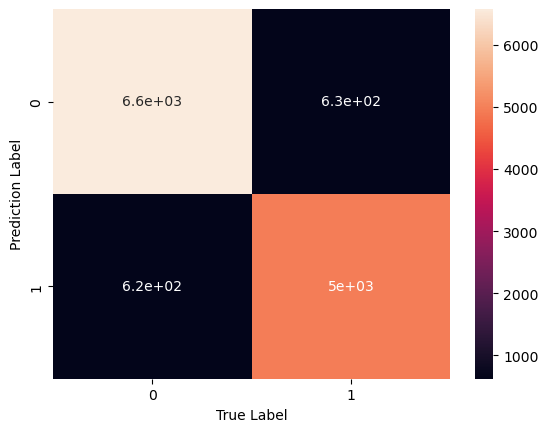

In [61]:
y_pred = RF2.predict(pca_x_test)
confusion_mat = confusion_matrix(y_test_transformed, y_pred)
ax = sns.heatmap(confusion_mat, annot=True)
ax.set(xlabel='True Label', ylabel='Prediction Label')
plt.show()

# 4.3 RandomForest

In [101]:
rf = RandomForestClassifier()
rf.fit(x_train_transformed, y_train_transformed)

RandomForestClassifier()

In [102]:
print(f'Score dla treningowego dla RandomForest: {rf.score(x_train_transformed,y_train_transformed)}')
print(f'Score dla testowego dla RandomForest: {rf.score(x_test_transformed,y_test_transformed)}')

Score dla treningowego dla RandomForest: 0.9998285733877327
Score dla testowego dla RandomForest: 0.9327253819694424


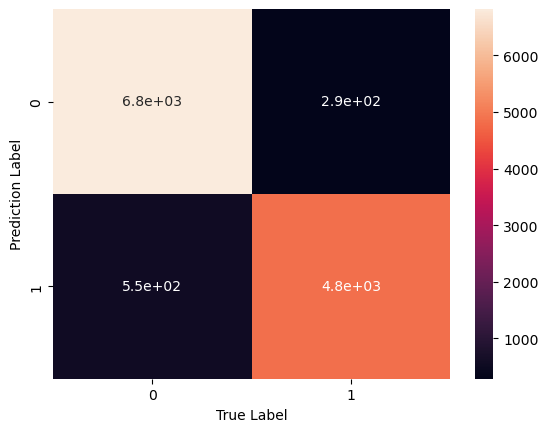

In [103]:
y_pred = rf.predict(x_test_transformed)
confusion_mat = confusion_matrix(y_test_transformed, y_pred)
ax = sns.heatmap(confusion_mat, annot=True)
ax.set(xlabel='True Label', ylabel='Prediction Label')
plt.show()

In [104]:
print(classification_report(y_pred,y_test_transformed))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      7365
           1       0.90      0.94      0.92      5136

    accuracy                           0.93     12501
   macro avg       0.93      0.93      0.93     12501
weighted avg       0.93      0.93      0.93     12501



# 4.4 XGboost

In [105]:
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(x_train_transformed,y_train_transformed)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [106]:
print(f'Score dla treningowego dla XGboost: {xgb_classifier.score(x_train_transformed,y_train_transformed)}')
print(f'Score dla testowego dla XGboost: {xgb_classifier.score(x_test_transformed,y_test_transformed)}')

Score dla treningowego dla XGboost: 0.9928343676072273
Score dla testowego dla XGboost: 0.9633629309655227


In [107]:
print(classification_report(y_pred,y_test_transformed))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      7365
           1       0.90      0.94      0.92      5136

    accuracy                           0.93     12501
   macro avg       0.93      0.93      0.93     12501
weighted avg       0.93      0.93      0.93     12501



# 4.* Słownik 

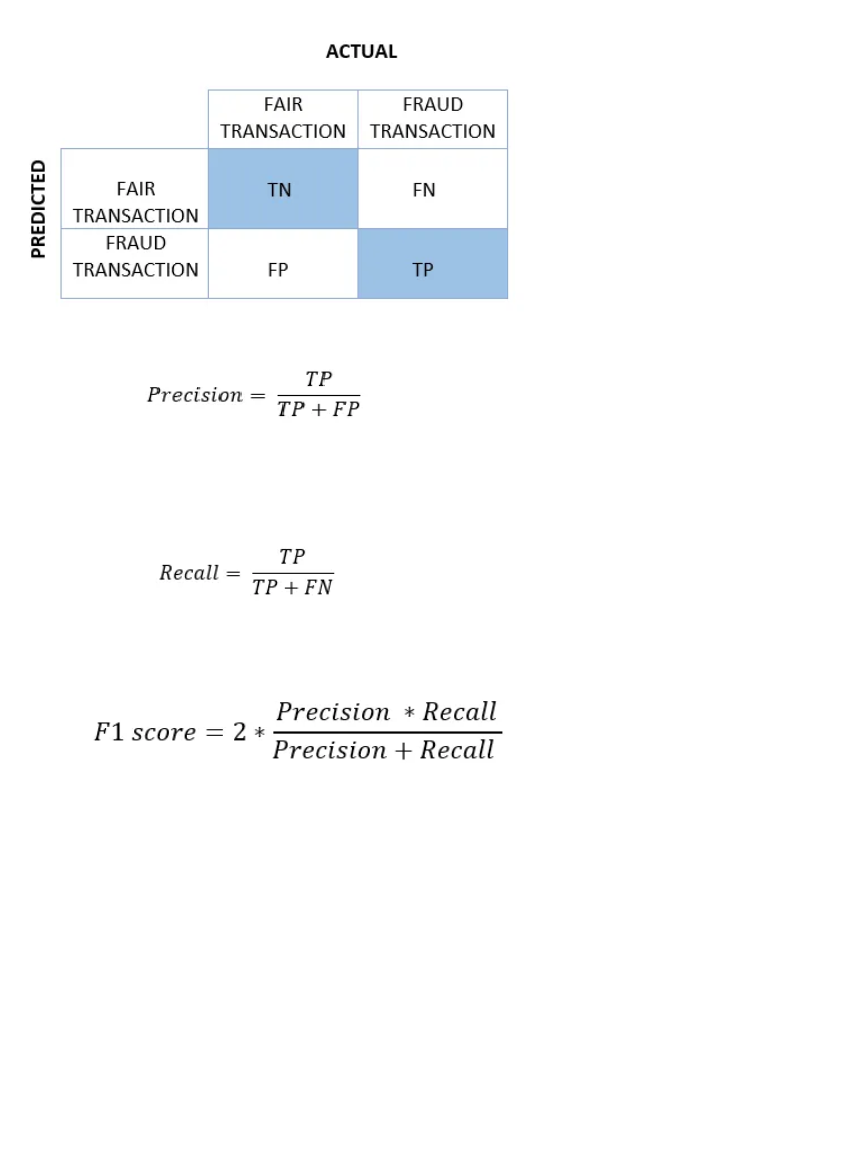

# 5. Strojenie hiperparametrów